# ADVANCED PSE+ STAKEHOLDER SUMMIT I 2023: 
# Interactive Code Demonstration Using WaterTAP

### Today's demonstration will show 
- Part 1: how to build, initialize, simulate, and optimize a flowsheet for multiperiod analysis. The demonstration will demonstrate the use of a reverse osmosis (RO) unit model.
- Part 2: :
    - Public Github Repository: https://github.com/watertap-org/watertap
    - Documentation: https://watertap.readthedocs.io/en/stable/
    - Installer for User Interface: https://watertap-org.github.io/

# Overall approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework.png" height="320">
</p>

## Part 1: Build, setup, and simulate the multiperiod RO+PV+Battery flowsheet


<p align="center">
  <img src="assets/RO_PV_Batt.svg">
</p>

## Multiperiod Setup
#### Import Pyomo, IDAES, and WaterTAP packages

In [50]:
# Pyomo imports
from pyomo.environ import ConcreteModel, Objective, Var, value, units as pyunits

# IDAES imports
from idaes.core import FlowsheetBlock
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
from idaes.apps.grid_integration.multiperiod.multiperiod import MultiPeriodModel
from idaes.core.solvers.get_solver import get_solver
# import idaes.logger as idaeslog
from idaes.core.solvers.get_solver import get_solver

### Import custom BatteryStorage model and define a method to define a battery

In [51]:
from steady_state_flowsheets.battery import BatteryStorage

def add_battery(m):
    """ This model does not use the flowsheet's time domain. Instead, it only models a single timestep, with initial
    conditions provided by `initial_state_of_charge` and `initial_energy_throughput`. The model calculates change
    in stored energy across a single time step using the power flow variables, `power_in` and `power_out`, and
    the `dr_hr` parameter."""

    m.fs.battery = BatteryStorage()
    m.fs.battery.charging_eta.set_value(0.95)    # Charging efficiency
    m.fs.battery.discharging_eta.set_value(0.95) # Discharging efficiency
    m.fs.battery.dt.set_value(1)                 # Time step

    return m.fs.battery

### Define critical variables:

In [52]:
def define_system_vars(m):
    if "USD_2021" not in pyunits._pint_registry:
            pyunits.load_definitions_from_strings(
                ["USD_2021 = 500/708.0 * USD_CE500"]
            )

    m.fs.pv_to_ro = Var(
            initialize = 100,
            bounds = (0,None),
            units = pyunits.kW,
            doc = 'PV to RO electricity'
        )
    m.fs.grid_to_ro = Var(
            initialize = 100,
            bounds = (0,None),
            units = pyunits.kW,
            doc = 'Grid to RO electricity'
        )
    m.fs.curtailment = Var(
            initialize = 0,
            bounds = (0,None),
            units = pyunits.kW,
            doc = 'PV curtailment'
        )

    m.fs.elec_price = Var(
            initialize = 0.1,
            bounds = (0,None),
            units = pyunits.USD_2021,
            doc = 'Electric Cost'
        )
    
    m.fs.electricity_price = Var(
            initialize = 0.1,
            bounds = (0,None),
            units = pyunits.USD_2021,
            doc = 'Electric Cost'
        )

    m.fs.elec_generation = Var(
            initialize = m.fs.pv_gen,
            bounds = (0,None),
            units = pyunits.kW,
            doc = 'PV Power Gen'
        )

### Add energy balance constraints

In [57]:
def add_steady_state_constraints(m):
    # Add energy flow balance
    @m.Constraint(doc="System energy flow")
    def eq_pv_elec_gen(b):
        return (
        m.fs.pv_gen == b.fs.pv_to_ro + b.fs.battery.elec_in[0] + b.fs.curtailment
        )

    @m.Constraint(doc="RO electricity requirment")
    def eq_ro_elec_req(b):
        return (m.fs.ro_elec_req == b.fs.pv_to_ro + b.fs.battery.elec_out[0] + b.fs.grid_to_ro
        )

    # Add grid electricity cost
    @m.Expression(doc="grid cost")
    def grid_cost(b):
        return (m.fs.electricity_price * b.fs.grid_to_ro * b.fs.battery.dt)

In [58]:
def fix_dof_and_initialize(
    m,
):
    """Fix degrees of freedom and initialize the flowsheet

    This function fixes the degrees of freedom of each unit and initializes the entire flowsheet.

    Args:
        m: Pyomo `Block` or `ConcreteModel` containing the flowsheet
        outlvl: Logger (default: idaeslog.WARNING)
    """
    m.fs.battery.initialize()

    return 

### Create a Pyomo concrete model and steady-state flowsheet

In [59]:
def build_pv_battery_flowsheet(
        m = None,
        pv_gen = 1000,
        electricity_price = 0.1,
        ro_capacity = 6000,
        ro_elec_req = 944.3,
        pv_oversize = 1):
    """

    Returns:
        object: A Pyomo concrete optimization model and flowsheet
    """
    if m is None:
        m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    m.fs.pv_gen = pv_gen
    m.fs.ro_elec_req = ro_elec_req
    m.fs.ro_capacity = ro_capacity
    m.fs.electricity_price = electricity_price
    m.fs.pv_size = pv_oversize*ro_elec_req

    add_battery(m)
    define_system_vars(m)
    add_steady_state_constraints(m)

    return m

In [60]:
m = build_pv_battery_flowsheet()
solver = get_solver()
fix_dof_and_initialize(m)
results = solver.solve(m)

for v in m.fs.component_data_objects(ctype=Var, active=True, descend_into=True):
        print(f'{str(v):<40s}', f'{value(v):<10,.1f}', pyunits.get_units(v))

    (model).fs with a new Component with type <class
    'pyomo.core.base.var.AbstractScalarVar'>. This is usually indicative of a
    modelling error. To avoid this warning, explicitly delete the attribute:
        del fs.electricity_price
2023-10-06 15:08:26 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.
fs.pv_to_ro                              194.4      kW
fs.grid_to_ro                            374.8      kW
fs.curtailment                           402.4      kW
fs.elec_price                            0.1        USD_2021
fs.electricity_price                     0.1        USD_2021
fs.elec_generation                       1,000.0    kW
fs.battery.nameplate_power               150,189.1  kW
fs.battery.nameplate_energy              278,058.9  kWh
fs.battery.initial_state_of_charge       121,922.4  kWh
fs.battery.initial_energy_throughput     99,811.5   kWh
fs.battery.elec_in[0.0]                  403.2      kWh
fs.battery.elec_out[0.0]

## Refresh - approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework.png" height="320">
</p>

In [61]:
def get_pv_ro_variable_pairs(t1, t2):
    """
    This function returns pairs of variables that need to be connected across two time periods

    Args:
        t1: current time block
        t2: next time block

    Returns:
        None
    """
    return [
        (t1.fs.battery.state_of_charge[0], t2.fs.battery.initial_state_of_charge),
        (t1.fs.battery.energy_throughput[0], t2.fs.battery.initial_energy_throughput),
        (t1.fs.battery.nameplate_power, t2.fs.battery.nameplate_power),
        (t1.fs.battery.nameplate_energy, t2.fs.battery.nameplate_energy),
        ]

In [62]:
def add_pv_ro_constraints(mp):
    """
    This function adds constraints that connect variables across two time periods

    Args:
        m: Pyomo model

    Returns:
        None
    """

    cost_battery_power = 75 # $/kW
    cost_battery_energy = 50 # $/kWh  
    n_time_points= 7*24
    ro_capacity = 6000 # m3/day

    @mp.Expression(doc="battery cost")
    def battery_capital_cost(b):
        return ((cost_battery_power * b.blocks[0].process.fs.battery.nameplate_power +
                 cost_battery_energy * b.blocks[0].process.fs.battery.nameplate_energy))
        
    # Add PV cost function
    @mp.Expression(doc="PV cost")
    def pv_capital_cost(b):
        return (0.37 * 1000 * b.blocks[0].process.fs.pv_size +
                0.03 * 1000 * b.blocks[0].process.fs.pv_size)

    @mp.Expression(doc="Capital cost")
    def total_capital_cost(b):
        return (b.battery_capital_cost + b.pv_capital_cost)
    
    @mp.Expression(doc="Annualized Capital cost")
    def annualized_capital_cost(b):
        return (b.total_capital_cost / 20)

    # Total cost
    @mp.Expression(doc='total cost')
    def total_cost(b):
        # The annualized capital cost is evenly distributed to the multiperiod
        return (
            (b.annualized_capital_cost) / 365 / 24 * n_time_points
            + sum([b.blocks[i].process.grid_cost for i in range(n_time_points)])
        )

    # LCOW
    @mp.Expression(doc='total cost')
    def LCOW(b):
        # LCOW from RO: 0.45
        return (
            0.40 + b.total_cost / (n_time_points*pyunits.convert(ro_capacity * pyunits.m**3 / pyunits.day, to_units=pyunits.m**3 / pyunits.hour))
        )   

    # Set objective
    mp.obj = Objective(expr=mp.LCOW)

In [63]:
def unfix_dof(m):
    """
    This function unfixes a few degrees of freedom for optimization

    Args:
        m: object containing the integrated nuclear plant flowsheet

    Returns:
        None
    """
    m.fs.battery.nameplate_energy.unfix()
    m.fs.battery.nameplate_power.unfix()


In [64]:
import pandas as pd

def load_surrogate(surrogate_filename='demo_surrogate.json'):
    return PysmoSurrogate.load_from_file(surrogate_filename)

def eval_surrogate(surrogate, design_size, Hour, Day):
    input = pd.DataFrame.from_dict([{'design_size':design_size, 'Hour':Hour, 'Day':Day}], orient='columns')
    hourly_gen = surrogate.evaluate_surrogate(input)
    return hourly_gen.values[0][0]

In [65]:
def load_flowsheet_options(mp,
        n_time_points= 7*24,
        ro_capacity = 6000, # m3/day
        ro_elec_req = 1000, # kW
        pv_oversize = 1,
        surrogate = None):
    
    flowsheet_options={ t: { 
                            "pv_gen": 1000,
                            "electricity_price": 0.1,
                            "ro_capacity": ro_capacity, 
                            "ro_elec_req": ro_elec_req,
                            "pv_oversize": pv_oversize} 
                            for t in range(n_time_points)
    }

    # create the multiperiod object
    mp.build_multi_period_model(
        model_data_kwargs=flowsheet_options,
        flowsheet_options={ "ro_capacity": ro_capacity, 
                            "ro_elec_req": ro_elec_req},)
    

In [66]:
def create_multiperiod_pv_battery_model(
        n_time_points= 7*24,        
    ):
    
    mp = MultiPeriodModel(
        n_time_points=n_time_points,
        process_model_func=build_pv_battery_flowsheet,
        linking_variable_func=get_pv_ro_variable_pairs,
        initialization_func=fix_dof_and_initialize,
        unfix_dof_func=unfix_dof,
    )

    # surrogate = load_surrogate()
    load_flowsheet_options(mp)
    mp.blocks[0].process.fs.battery.initial_state_of_charge.fix(0)
    add_pv_ro_constraints(mp)
    
    return mp

In [67]:
mp = create_multiperiod_pv_battery_model()
results = solver.solve(mp)

[+   0.00] Beginning the formulation of the multiperiod optimization problem.
2023-10-06 15:08:26 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[0]
    (model).fs with a new Component with type <class
    'pyomo.core.base.var.AbstractScalarVar'>. This is usually indicative of a
    modelling error. To avoid this warning, explicitly delete the attribute:
        del fs.electricity_price
2023-10-06 15:08:26 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[1]
    (model).fs with a new Component with type <class
    'pyomo.core.base.var.AbstractScalarVar'>. This is usually indicative of a
    modelling error. To avoid this warning, explicitly delete the attribute:
        del fs.electricity_price
2023-10-06 15:08:26 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: ...Constructing the flowsheet model for blocks[2]
    (model).fs with a new Component with type <cla

In [68]:
labels = ['pv_size', 'battery_power', 'battery_energy', 'LCOW']
for idx, v in enumerate([mp.blocks[0].process.fs.pv_size, mp.blocks[0].process.fs.battery.nameplate_power, mp.blocks[0].process.fs.battery.nameplate_energy, mp.LCOW]):
    print(f'{labels[idx]:<20s}', f'{value(v):<10,.2f}')

pv_size              1,000.00  
battery_power        148,921.16
battery_energy       216,401.70
LCOW                 0.91      


ValueError: x and y must have same first dimension, but have shapes (168,) and (2,)

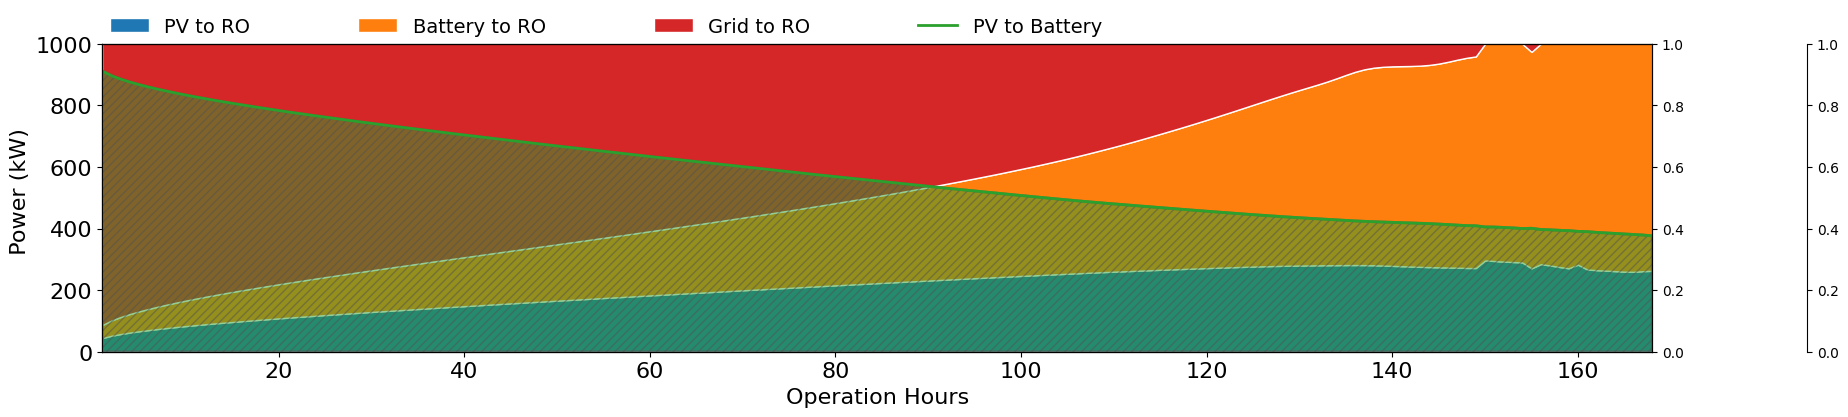

In [71]:
from util.visualize import create_plot
create_plot(mp, [0,1])